In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
%%time
df = pd.read_csv('data/data.csv')

num_movies = 10000
assert num_movies < 17770
df = df[df['movie'] < num_movies]

CPU times: user 40.3 s, sys: 7.4 s, total: 47.7 s
Wall time: 47.5 s


## Getting the movies
Let's start by getting the least popular "half" of the movies. We can do this by finding how many ratings each movie has and choosing those which fall below a certain threshold.

/thayerfs/home/f0031b9/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


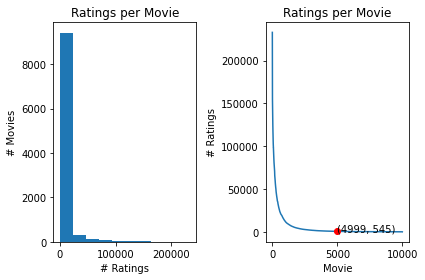

In [17]:
ratings_per_movie = df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2)

num_bins = 10
ax1.set_title('Ratings per Movie')
ax1.set_ylabel('# Movies')
ax1.set_xlabel('# Ratings')
ax1.hist(ratings_per_movie, bins=num_bins)

x = int(len(ratings_per_movie)/2)
y = ratings_per_movie.values[x-1]
ax2.set_title('Ratings per Movie')
ax2.set_xlabel('Movie')
ax2.set_ylabel('# Ratings')
ax2.plot(ratings_per_movie.values)
ax2.plot(x, y, 'ro')
ax2.annotate(s='({}, {})'.format(x, y), xy=(x, y))

plt.tight_layout()
plt.show()

In [18]:
step = 0.25
ratings_per_movie.quantile(np.arange(0, 1+step, step))

0.00        10.0
0.25       188.0
0.50       545.0
0.75      2673.5
1.00    232944.0
Name: rating, dtype: float64

In [19]:
cutoff = 0.5
least_pop_movies = ratings_per_movie.keys()[int(1-cutoff*len(ratings_per_movie)):]

unpopular_movies_df = df[df['movie'].isin(least_pop_movies)]

We now have all of the ratings for the less popular movies stored in `unpopular_movies_df`. We can either run a new SVD on this subset, or we can index into our master SVD (run on the whole data) to continue with the visualization. Let's do the latter, as it will take less time.

In [20]:
%%time
from surprise.dump import load
model = load('models/svd_model.pickle')[1]

CPU times: user 1min 6s, sys: 23.2 s, total: 1min 29s
Wall time: 1min 29s


In [21]:
genres_df = pd.read_csv('data/nflx_imdb_interscetion.csv')
genres_df = genres_df[genres_df['ID'].isin(least_pop_movies)]

In [22]:
# We have the raw IDs of the least popular movies.
# Now we want to turn that list into inner_ids for surprise,
# turn that into the latent rep, 
# TSNE on that, 
# and then connect the 2d latent rep back to the original df
from sklearn.manifold import TSNE

raw_ids = genres_df.ID.values
inner_ids = [model.trainset.to_inner_iid(raw_id) for raw_id in raw_ids]
latent_reps = model.qi[inner_ids]
latent_rep_2d = TSNE(learning_rate=50, random_state=0).fit_transform(latent_reps)
genres_df['latent_X'] = latent_rep_2d[:,0]
genres_df['latent_Y'] = latent_rep_2d[:,1]

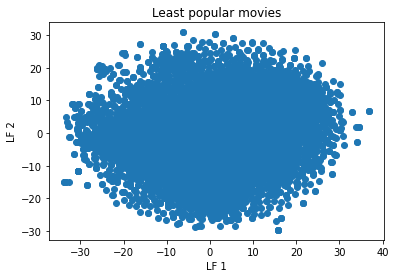

In [23]:
# Let's plot the less popular movies
plt.title('Least popular movies')
plt.xlabel('LF 1')
plt.ylabel('LF 2')
plt.scatter(
    x=genres_df.latent_X, y=genres_df.latent_Y,
)

Ok so that is the plot for all of the movies. Let's try a tent pole method where we plot onlt the movies which have one genre associated with them. Hopefully we can start to see some clusters there.

In [24]:
# first let's create a df that onl ahs the movies which ahve one tag
single_tags_df = genres_df[~genres_df.fillna(',')['genres'].str.contains(',')]

single_tags_df.genres.unique()

array(['Documentary', 'Drama', 'Action', 'Horror', 'Short', 'Western',
       'Comedy', 'Music', 'Romance', 'Thriller', 'Animation', 'Family',
       'Musical', 'Adventure', 'Sci-Fi', 'History', 'Sport', 'Fantasy',
       'Adult', 'Talk-Show', 'Reality-TV'], dtype=object)

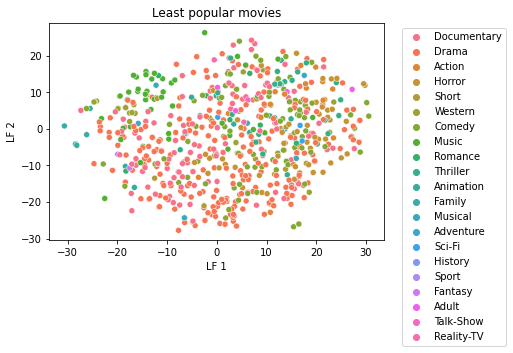

In [25]:
# Plot these with hue for genre
plt.title('Least popular movies')
plt.xlabel('LF 1')
plt.ylabel('LF 2')
sns.scatterplot(
    x=single_tags_df.latent_X, y=single_tags_df.latent_Y,
    hue=single_tags_df.genres
)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")